# MSc Project
## Adaptive Classifier for Concept Drift with Web Interface for Fraud DetectionStakeholder

In [3]:
import zipfile
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

from imblearn.over_sampling import SMOTE
from scipy.stats import ttest_rel, wilcoxon

import joblib
from copy import deepcopy
import shap

import warnings
warnings.filterwarnings('ignore')

# 1. Extracting and Subsetting


_N:B: Section 1 only needs to be run once (the first time this notebook is run) with archive.zip. The results of this extracting and subsetting is saved in the "data/processed/paysim_subsample.csv" file and is used forward from Section 2._

## 1.1. Extract from archive

In [ ]:
# !! cell can be commented out after the first run as it has served it's purpose !!
# extract data from archive

zip_file = "data/raw/archive.zip"
extract_dir = "data/raw/"

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

## 1.2. Load and Inspect Data

In [7]:
full_data_dir = "data/raw/PS_20174392719_1491204439457_log.csv"
full_df = pd.read_csv(full_data_dir)

In [8]:
print(full_df.info())
full_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
print(f"Full Dataset: {len(full_df)} row, Fraud Rate: {full_df['isFraud'].mean():.4f}")

Full Dataset: 6362620 row, Fraud Rate: 0.0013


In [10]:
# check for missing data
full_df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## 1.3. Subsample Data
Select a subsample of 100,000 records

In [11]:
full_df = full_df.reset_index(names='original_index') # preserve original index for temporality
full_df.head()

,original_index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
# select all fraud cases
fraud_df = full_df[full_df['isFraud']==1]
print(fraud_df.info())
fraud_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8213 entries, 2 to 6362619
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   original_index  8213 non-null   int64  
 1   step            8213 non-null   int64  
 2   type            8213 non-null   object 
 3   amount          8213 non-null   float64
 4   nameOrig        8213 non-null   object 
 5   oldbalanceOrg   8213 non-null   float64
 6   newbalanceOrig  8213 non-null   float64
 7   nameDest        8213 non-null   object 
 8   oldbalanceDest  8213 non-null   float64
 9   newbalanceDest  8213 non-null   float64
 10  isFraud         8213 non-null   int64  
 11  isFlaggedFraud  8213 non-null   int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 834.1+ KB
None


,original_index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [13]:
# select non-fraud cases to make up 100,000 records
to_select = 120000
count_req_non_fraud = to_select - len(fraud_df) # number of fraud cases required to make up 100000 total cases
count_total_non_fraud = len(full_df) - len(fraud_df) # total number of fraud cases in dataset
non_fraud_ratio = count_req_non_fraud / count_total_non_fraud # fraction of required to total,  to ensure proportional subseting

nonfraud_df = full_df[full_df['isFraud']==0].groupby('step').sample(frac=non_fraud_ratio, random_state=42)
print(nonfraud_df.info())
nonfraud_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 111785 entries, 1795 to 6361797
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   original_index  111785 non-null  int64  
 1   step            111785 non-null  int64  
 2   type            111785 non-null  object 
 3   amount          111785 non-null  float64
 4   nameOrig        111785 non-null  object 
 5   oldbalanceOrg   111785 non-null  float64
 6   newbalanceOrig  111785 non-null  float64
 7   nameDest        111785 non-null  object 
 8   oldbalanceDest  111785 non-null  float64
 9   newbalanceDest  111785 non-null  float64
 10  isFraud         111785 non-null  int64  
 11  isFlaggedFraud  111785 non-null  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 11.1+ MB
None


,original_index,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1795,1795,1,PAYMENT,353.90,C1746117425,3.00,0.00,M467146800,0.00,0.00,0,0
2233,2233,1,CASH_OUT,159657.10,C1366629983,0.00,0.00,C716083600,2640580.83,2444985.19,0,0
372,372,1,TRANSFER,438437.09,C977160959,0.00,0.00,C248609774,740675.45,6453430.91,0,0
539,539,1,PAYMENT,207.75,C1288108586,82149.35,81941.60,M1089584667,0.00,0.00,0,0
2440,2440,1,PAYMENT,11380.13,C1905114489,77037.91,65657.79,M538132628,0.00,0.00,0,0


In [14]:
subsample_df = pd.concat([fraud_df, nonfraud_df], ignore_index=True)
# sort transactions by original index
subsample_df = subsample_df.sort_values(by='original_index').reset_index(drop=True)
# drop the original index
subsample_df.drop(columns=["original_index"], inplace=True)
print(subsample_df.info())
subsample_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119998 entries, 0 to 119997
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            119998 non-null  int64  
 1   type            119998 non-null  object 
 2   amount          119998 non-null  float64
 3   nameOrig        119998 non-null  object 
 4   oldbalanceOrg   119998 non-null  float64
 5   newbalanceOrig  119998 non-null  float64
 6   nameDest        119998 non-null  object 
 7   oldbalanceDest  119998 non-null  float64
 8   newbalanceDest  119998 non-null  float64
 9   isFraud         119998 non-null  int64  
 10  isFlaggedFraud  119998 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 10.1+ MB
None


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.00,0.00,1,0
2,1,TRANSFER,710544.77,C835773569,0.0,0.0,C1359044626,738531.50,16518.36,0,0
3,1,CASH_OUT,220691.42,C1123559518,0.0,0.0,C1590550415,6093090.62,19169204.93,0,0
4,1,TRANSFER,2806.00,C1420196421,2806.0,0.0,C972765878,0.00,0.00,1,0


In [15]:
print(f"Subsample Dataset: {len(subsample_df)} rows")
print("_________Composed Of_________")
print(f"{len(subsample_df.query('isFraud==1'))} Fraud Cases")
print(f"{len(subsample_df.query('isFraud==0'))} Non-Fraud Cases")
print(f"Fraud Rate: {subsample_df['isFraud'].mean():.4f}")

Subsample Dataset: 119998 rows
_________Composed Of_________
8213 Fraud Cases
111785 Non-Fraud Cases
Fraud Rate: 0.0684


99,999 cases have been retrieved (rather than an exact 100,000) due to proportional subsampling.

In [18]:
# save the subset data
subsample_path = "data/processed/paysim_subsample_120k.csv"
subsample_df.to_csv(subsample_path, index=False)

# 2. Preprocess Data

Process Data into format needed for model training and other subsequent manipulation

## 2.1 Load Subsampled Dataset
Load and inspect susbsampled dataset

In [8]:
df = pd.read_csv("data/processed/paysim_subsample_120k.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119998 entries, 0 to 119997
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            119998 non-null  int64  
 1   type            119998 non-null  object 
 2   amount          119998 non-null  float64
 3   nameOrig        119998 non-null  object 
 4   oldbalanceOrg   119998 non-null  float64
 5   newbalanceOrig  119998 non-null  float64
 6   nameDest        119998 non-null  object 
 7   oldbalanceDest  119998 non-null  float64
 8   newbalanceDest  119998 non-null  float64
 9   isFraud         119998 non-null  int64  
 10  isFlaggedFraud  119998 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 10.1+ MB
None


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.00,0.00,1,0
2,1,TRANSFER,710544.77,C835773569,0.0,0.0,C1359044626,738531.50,16518.36,0,0
3,1,CASH_OUT,220691.42,C1123559518,0.0,0.0,C1590550415,6093090.62,19169204.93,0,0
4,1,TRANSFER,2806.00,C1420196421,2806.0,0.0,C972765878,0.00,0.00,1,0


Inspect data

## 2.2. Feature Engineering and Selection

Select features, excluding:
- high cardinality data: nameOrig, nameDest
- Engineer new feature (isMerchant) from nameDest
- others: isFlaggedFraud. This is only a baseline system and will only be used as to derive baseline metrics for the system being built.

In [60]:
# list out features to select. step is excluded here because it will be used to engineer a new feature
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
X = df[features]
y = df['isFraud']

# Engineer time feature from step (step represents time units in hours). Results in 0-23hrs for each day
df['hour'] = (df['step'] % 24).astype(int)

# add it into the X set
X['hour'] = df['hour']
# add hour to the list of features
features.append('hour')

# preserve the amount unscaled for use in cost evaluation
unscaled_amount = df['amount'].copy()

# normalize features
# standard scaler normalizes data with mean = 0 and standard deviation = 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

## 2.3. Apply SMOTE for Oversampling

- Cut the data into three time periods (necessary for simulating drift)
- Apply SMOTE to each of the time periods separately (necessary to avoid synthetic data not specific to time period, and to avoid length mismatch)

The scaler and SMOTE cannot handle string variables, hence the labels have to be added after applying both.

In [61]:
# Simulate Concept Drift: split data into three time periods
no_splits = 12 # no of data splits to create


periods = [i for i in range(1, no_splits+1)]
df['time_period'] = pd.qcut(df['step'], q=no_splits, labels=periods)

# Initialize SMOTE (1:3 fraud-to-non-fraud), will be applied separately for each time period
smote = SMOTE(random_state=42, sampling_strategy=0.55)

# add unscaled amount to X_scaled before oversampling
X_scaled['unscaled_amount'] = unscaled_amount

# add a flag to flag merchant destination accounts
X_scaled['isMerchant'] = df.nameDest.str.startswith('M').astype('int')
features.extend(['unscaled_amount', 'isMerchant'])

X_bal_list, y_bal_list = [], []
for period in periods:
    mask = df['time_period'] == period
    X_period = X_scaled[mask][features]
    y_period = y[mask]

    # apply SMOTE
    X_bal, y_bal = smote.fit_resample(X_period, y_period)
    X_bal['time_period'] = period

    X_bal_list.append(X_bal)
    y_bal_list.append(pd.Series(y_bal))

X_balanced = pd.concat(X_bal_list, ignore_index=True)
y_balanced = pd.concat(y_bal_list, ignore_index=True)

In [62]:
X_balanced.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,hour,unscaled_amount,isMerchant,time_period
0,-0.300367,-0.301486,-0.281613,-0.329410,-0.352762,-3.034355,181.00,0,1
1,-0.300367,-0.301486,-0.281613,-0.322883,-0.352762,-3.034355,181.00,0,1
2,0.510774,-0.301548,-0.281613,-0.101868,-0.348032,-3.034355,710544.77,0,1
3,-0.048573,-0.301548,-0.281613,1.547874,5.137015,-3.034355,220691.42,0,1
4,-0.297369,-0.300584,-0.281613,-0.329410,-0.352762,-3.034355,2806.00,0,1


In [64]:
X_balanced.time_period.value_counts().sort_index()

time_period
1     15400
2     13460
3     15203
4     14968
5     15241
6     15186
7     14632
8     14765
9     15078
10    15537
11    13745
12    10047
Name: count, dtype: int64

In [65]:
print(f"Post-SMOTE: {len(X_balanced)} rows, Fraud rate: {y_balanced.mean()}")

# save preprocessed X and y data, and save scaler model for reuse
X_balanced.to_csv("data/processed/X_preprocessed.csv", index=False)
y_balanced.to_csv("data/processed/y_preprocessed.csv", index=False)
joblib.dump(scaler, "models/scaler.pkl")

Post-SMOTE: 173262 rows, Fraud rate: 0.35482102249772024


['models/scaler.pkl']

# 3. Model Training
- Get a baseline score
- Train on early, mid and then late data to adapt model.

## 3.1. Baseline Metrics
From the flagging system

### 3.1.1 Define Evaluation Function

In [3]:
def evaluate_model(y_true: pd.Series, y_pred: pd.Series, amount: pd.Series, model_name: str = "Model Name"):
    """ Reusable function to evaluate all models
    y_true (pd.Series): Actual values
    y_pred (pd.Series): Predicted values
    amount (pd.Series): Transaction amount
    model_name (str): Name of model being evaluated
    
    Return:
    matrics_dict (dict): dictionary containing responses
    confusion_matrix (visualization)
    recall,
    cost_saved,
    net_saved"""

    # implement cost-based evaluation
    fraud_mask = (y_true == 1)
    cost_saved = amount[fraud_mask & (y_pred==1)].sum()
    cost_lost = amount[fraud_mask & (y_pred==0)].sum()
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    metrics_dict = {
        "model_name": model_name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1score": f1_score(y_true, y_pred),
        "true_positives": conf_matrix[1][1], # saved money by correctly identifing actual fraud cases
        "false_negatives": conf_matrix[1][0], # lost money by missing actual fraud cases
        "cost_saved": cost_saved,
        "cost_lost": cost_lost,
        "net_saved": cost_saved - cost_lost
    }
    return metrics_dict

### 3.1.2. Establish Baseline

In [9]:
y_true = df['isFraud']
y_pred = df['isFlaggedFraud']
amount = df['amount']

base_metrics = evaluate_model(y_true, y_pred, amount, "Baseline")
base_metrics

{'model_name': 'Baseline',
 'accuracy': 0.9316905281754696,
 'precision': 1.0,
 'recall': 0.0019481310118105442,
 'f1score': 0.0038886863531413293,
 'true_positives': 16,
 'false_negatives': 8197,
 'cost_saved': 77785563.69,
 'cost_lost': 11978629864.15,
 'net_saved': -11900844300.46}

In [5]:
X = pd.read_csv("data/processed/X_preprocessed.csv")
y = pd.read_csv("data/processed/y_preprocessed.csv").values.ravel()

X.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,hour,unscaled_amount,isMerchant,time_period
0,-0.300367,-0.301486,-0.281613,-0.329410,-0.352762,-3.034355,181.00,0,1
1,-0.300367,-0.301486,-0.281613,-0.322883,-0.352762,-3.034355,181.00,0,1
2,0.510774,-0.301548,-0.281613,-0.101868,-0.348032,-3.034355,710544.77,0,1
3,-0.048573,-0.301548,-0.281613,1.547874,5.137015,-3.034355,220691.42,0,1
4,-0.297369,-0.300584,-0.281613,-0.329410,-0.352762,-3.034355,2806.00,0,1


## 3.2. Train Models

**RandomForestClassifier** is model of choice for the following reasons:
- Handles Imbalance: it handles class imbalance well
- Non-Linear Relationships: captures complex patterns
- Robustness: less sensitive to outliers
- Scalability: works well with datasets of varying sizes
- Interpretability: inbuilt feature importances, supports SHAP
- Baseline Fit: matches periodic retraining and cost based evaluation

Alternatives to RandomForestClassifier include:
- XGBoost (EXtreme Gradient Boosting) Classifier
- LogisticRegression: simpler and faster

In [94]:
def train_adapt_models(X=None, y=None, model=None, periods=None, directory=None) -> dict:
    """ Handles training of models and concept drift adaptation"""
    # initialize model
    # if no model is passed in, defaults to RandomForestClassifier
    if model is None:
        model = RandomForestClassifier(random_state=42)
    if not periods:
        periods=12

    # initialize static model that will be saved after first run
    static_model = None

    # store model metrics
    adaptive_model_metrics = {}
    static_model_metrics = {}

    train_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',\
                      'newbalanceDest', 'hour', 'isMerchant']

    models_dir = Path("models", directory)
    models_dir.mkdir(exist_ok=True)

    for i in range(len(periods)-1):
        train_mask = X['time_period'] == periods[i] # train on current data batch
        eval_mask = X['time_period'] == periods[i+1] # evaluate on next batch
        
        X_train = X[train_mask][train_features]
        y_train = y[train_mask]

        X_test = X[eval_mask]
        y_test = y[eval_mask]
        
        model.fit(X_train, y_train)
        
        # save static model on first run
        if i == 0:
            static_model = deepcopy(model)

        model_name = f"model_{i+1}"

        # evalute adaptive model on next batch
        y_pred = model.predict(X_test[train_features])
        adaptive_model_metrics[model_name] = evaluate_model(\
            y_test, y_pred, X_test['unscaled_amount'], model_name)
        
        # evaluate static model on next batch
        y_pred_static = static_model.predict(X_test[train_features])
        static_model_metrics[model_name] = evaluate_model(\
            y_test, y_pred_static, X_test['unscaled_amount'], model_name)
        
        joblib.dump(model, f"{models_dir}/{model_name}.pkl")
        print(f"Trained {model_name}")

    return {
        "adaptive_model_metrics": adaptive_model_metrics,
        "static_model_metrics": static_model_metrics
    }

In [166]:
all_metrics = train_adapt_models(periods)

Trained model_1
Trained model_2
Trained model_3
Trained model_4
Trained model_5
Trained model_6
Trained model_7
Trained model_8
Trained model_9
Trained model_10
Trained model_11


In [168]:
adaptive_metrics = all_metrics['adaptive_model_metrics']
static_metrics = all_metrics['static_model_metrics']

In [169]:
adaptive_metrics['baseline'] = base_metrics
adaptive_metrics_df = pd.DataFrame.from_dict(adaptive_metrics, orient='index')
adaptive_metrics_df = adaptive_metrics_df.reindex(np.roll(adaptive_metrics_df.index, shift=1))
adaptive_metrics_df

,model_name,accuracy,precision,recall,f1score,true_positives,false_negatives,cost_saved,cost_lost,net_saved
baseline,Baseline,0.931691,1.000000,0.001948,0.003889,16,8197,7.778556e+07,1.197863e+10,-1.190084e+10
model_1,model_1,0.972511,0.974580,0.947236,0.960714,4524,252,6.263986e+09,6.382254e+07,6.200163e+09
model_2,model_2,0.990462,0.986649,0.986466,0.986558,5321,73,7.084028e+09,5.722934e+06,7.078306e+09
model_3,model_3,0.977686,0.989381,0.947279,0.967872,5031,280,7.960064e+09,3.536578e+07,7.924699e+09
model_4,model_4,0.965685,0.995135,0.907729,0.949425,4909,499,6.974413e+09,5.807475e+07,6.916339e+09
model_5,model_5,0.965297,0.989921,0.911470,0.949077,4911,477,7.898774e+09,5.545758e+08,7.344198e+09
model_6,model_6,0.985306,0.987846,0.970532,0.979112,5039,153,7.792994e+09,1.759821e+07,7.775396e+09
model_7,model_7,0.968100,0.989528,0.919832,0.953408,4819,420,7.396567e+09,2.354921e+07,7.373018e+09
model_8,model_8,0.961666,0.993587,0.897757,0.943244,4803,547,6.194788e+09,1.543674e+08,6.040421e+09
model_9,model_9,0.967626,0.991562,0.916561,0.952587,5053,460,9.195078e+09,3.818374e+07,9.156894e+09


In [170]:
static_metrics['baseline'] = base_metrics
static_metrics_df = pd.DataFrame.from_dict(static_metrics, orient='index')
static_metrics_df = static_metrics_df.reindex(np.roll(static_metrics_df.index, shift=1))
static_metrics_df

,model_name,accuracy,precision,recall,f1score,true_positives,false_negatives,cost_saved,cost_lost,net_saved
baseline,Baseline,0.931691,1.000000,0.001948,0.003889,16,8197,7.778556e+07,1.197863e+10,-1.190084e+10
model_1,model_1,0.972511,0.974580,0.947236,0.960714,4524,252,6.263986e+09,6.382254e+07,6.200163e+09
model_2,model_2,0.973689,0.975619,0.949574,0.962420,5122,272,7.003655e+09,8.609627e+07,6.917559e+09
model_3,model_3,0.977819,0.975005,0.962154,0.968537,5110,201,7.953690e+09,4.174053e+07,7.911949e+09
model_4,model_4,0.968768,0.981265,0.929734,0.954804,5028,380,6.948053e+09,8.443563e+07,6.863617e+09
model_5,model_5,0.972870,0.977727,0.945063,0.961117,5092,296,8.374497e+09,7.885293e+07,8.295644e+09
model_6,model_6,0.975260,0.972603,0.957242,0.964861,4970,222,7.755012e+09,5.558060e+07,7.699431e+09
model_7,model_7,0.985913,0.981435,0.978813,0.980122,5128,111,7.395905e+09,2.421128e+07,7.371693e+09
model_8,model_8,0.980966,0.980634,0.965421,0.972968,5165,185,6.308908e+09,4.024796e+07,6.268660e+09
model_9,model_9,0.974255,0.978297,0.948485,0.963161,5229,284,9.180990e+09,5.227195e+07,9.128718e+09


In [177]:
to_copy = ['f1score', 'net_saved', 'true_positives', 'false_negatives']
combined_metrics_df = adaptive_metrics_df[to_copy].copy()
combined_metrics_df = combined_metrics_df.join(static_metrics_df[to_copy].copy(),\
                                         lsuffix='_adaptive', rsuffix='_static')
combined_metrics_df = combined_metrics_df.iloc[2:] # skip baseline model and model 1
combined_metrics_df

,f1score_adaptive,net_saved_adaptive,true_positives_adaptive,false_negatives_adaptive,f1score_static,net_saved_static,true_positives_static,false_negatives_static
model_2,0.986558,7.078306e+09,5321,73,0.962420,6.917559e+09,5122,272
model_3,0.967872,7.924699e+09,5031,280,0.968537,7.911949e+09,5110,201
model_4,0.949425,6.916339e+09,4909,499,0.954804,6.863617e+09,5028,380
model_5,0.949077,7.344198e+09,4911,477,0.961117,8.295644e+09,5092,296
model_6,0.979112,7.775396e+09,5039,153,0.964861,7.699431e+09,4970,222
model_7,0.953408,7.373018e+09,4819,420,0.980122,7.371693e+09,5128,111
model_8,0.943244,6.040421e+09,4803,547,0.972968,6.268660e+09,5165,185
model_9,0.952587,9.156894e+09,5053,460,0.963161,9.128718e+09,5229,284
model_10,0.953506,9.279412e+09,4481,396,0.958325,9.349777e+09,4576,301
model_11,0.968634,5.414301e+09,3397,168,0.960558,5.343861e+09,3373,192


## 3.3 Evaluate Adaptation vs Static Model performances

### 3.3.1 Define Helper Functions

In [ ]:
def plot_metric(df: pd.DataFrame, metric_type: str, ax=None):
    """ Plot metric
    df(pd.DataFrame): dataframe
    metric_type(str): the metric to plot
    ax: axis to plot on
    Returns:
    a plt object containin the plot
    """
    fig = plt.figure()
    sb.lineplot(df[[f"{metric_type}_adaptive", f"{metric_type}_static"]], ax=ax, marker='o')
    return fig

def run_ttest(adaptive_costs, static_costs):
    t_stat, p_value = ttest_rel(adaptive_costs, static_costs)
    return t_stat, p_value

def run_wilcoxon(adaptive_costs, static_costs):
    stat, p_value = wilcoxon(adaptive_costs, static_costs)
    return stat, p_value

### 3.3.2 Comparison and Testing Function

In [123]:
# define function to compare performances of adaptive against static models
def compare_performances(metrics: dict, name: str) -> dict:
    """ Compare performances of static and adaptive models
    metric(dict): a dict of two dictionaries containing the metrics
    name(str): name to identify the model by
    """

    adaptive_metrics = metrics['adaptive_model_metrics']
    static_metrics = metrics['static_model_metrics']

    # create df of metrics of adaptive models
    adaptive_metrics['baseline'] = base_metrics
    adaptive_metrics_df = pd.DataFrame.from_dict(adaptive_metrics, orient='index')
    adaptive_metrics_df = adaptive_metrics_df.reindex(np.roll(adaptive_metrics_df.index, shift=1))

    # create df of metrics of static model
    static_metrics['baseline'] = base_metrics
    static_metrics_df = pd.DataFrame.from_dict(static_metrics, orient='index')
    static_metrics_df = static_metrics_df.reindex(np.roll(static_metrics_df.index, shift=1))

    # combine the two tables
    to_copy = ['net_saved', 'f1score', 'true_positives', 'false_negatives']
    combined_metrics_df = adaptive_metrics_df[to_copy].copy()
    combined_metrics_df = combined_metrics_df.join(static_metrics_df[to_copy].copy(),\
                                            lsuffix='_adaptive', rsuffix='_static')
    combined_metrics_df = combined_metrics_df.iloc[2:] # skip baseline and model 1

    combined_metrics_df['cumm_net_saved_adaptive'] = combined_metrics_df['net_saved_adaptive'].cumsum()
    combined_metrics_df['cumm_net_saved_static'] = combined_metrics_df['net_saved_static'].cumsum()

    to_plot = ['cumm_net_saved', 'f1score', 'true_positives', 'false_negatives']
    fig, axes = plt.subplots(4,1, figsize=(5, 12), sharex=True)
    ax_tracker = 0
    for metric in to_plot:
        ax = axes[ax_tracker]
        plot_metric(combined_metrics_df, metric, ax=ax)
        ax.set_title(metric);
        ax.tick_params(axis='x', rotation=90)
        ax_tracker = ax_tracker + 1
    fig.suptitle(f"{name}: Adaptive vs Static Models")
    fig.tight_layout()

    # run test for significane (wilcoxon due to high variance)
    stat, p_value = run_wilcoxon(combined_metrics_df['net_saved_adaptive'], combined_metrics_df['net_saved_static'])
    
    return {
        "chart": fig,
        "wilcoxon_stat": stat,
        "p-value": p_value,
        "combined_metrics_df": combined_metrics_df
    }

# results = compare_performances(all_metrics)

### 3.3.4 Iteration Pipeline

In [90]:
# define full iteration pipeline
def iterate_pipeline(X, y, model, periods, name):
    """ iterate on various models
    X: parameter set
    y: target
    model: model to iterate on
    periods: number of time splits
    name: name to identify the model by

    Return: dict containing chart, wilcoxon stat and p-value
    """

    # convert period into list format
    periods = [i for i in range(1, periods+1)]
    metrics = train_adapt_models(X, y, model, periods, name)
    results = compare_performances(metrics, name)

    return results

In [31]:
X = pd.read_csv("data/processed/X_preprocessed.csv")
y = pd.read_csv("data/processed/y_preprocessed.csv").values.ravel()

Trained model_1
Trained model_2
Trained model_3
Trained model_4
Trained model_5
Trained model_6
Trained model_7
Trained model_8
Trained model_9
Trained model_10
Trained model_11


{'chart': <Figure size 500x1200 with 4 Axes>,
 'wilcoxon_stat': 24.0,
 'p-value': 0.76953125,
 'combined_metrics_df':           net_saved_adaptive  f1score_adaptive  true_positives_adaptive  \
 model_2         7.078306e+09          0.986558                     5321   
 model_3         7.924699e+09          0.967872                     5031   
 model_4         6.916339e+09          0.949425                     4909   
 model_5         7.344198e+09          0.949077                     4911   
 model_6         7.775396e+09          0.979112                     5039   
 model_7         7.373018e+09          0.953408                     4819   
 model_8         6.040421e+09          0.943244                     4803   
 model_9         9.156894e+09          0.952587                     5053   
 model_10        9.279412e+09          0.953506                     4481   
 model_11        5.414301e+09          0.968634                     3397   
 
           false_negatives_adaptive  net_save

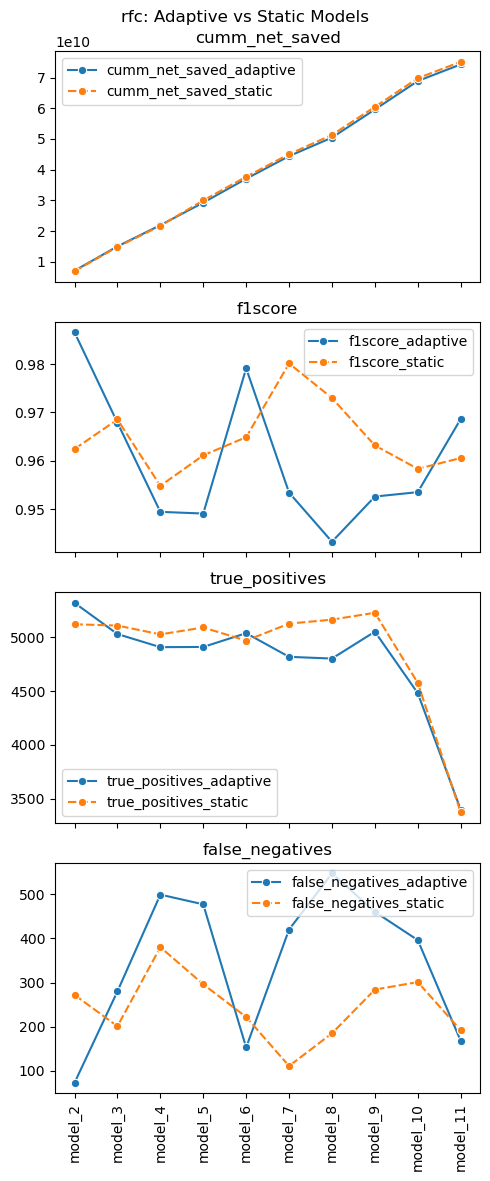

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [130]:
model = RandomForestClassifier(random_state=42)
periods = 12

results_rfc = iterate_pipeline(X=X, y=y, model=model, periods=periods, name="rfc")
results_rfc

In [103]:
results_rfc['combined_metrics_df']

,net_saved_adaptive,cumm_net_saved_adaptive,f1score_adaptive,true_positives_adaptive,false_negatives_adaptive,net_saved_static,cumm_net_saved_static,f1score_static,true_positives_static,false_negatives_static
model_2,7.078306e+09,1.377624e+09,0.986558,5321,73,6.917559e+09,1.216878e+09,0.962420,5122,272
model_3,7.924699e+09,9.302323e+09,0.967872,5031,280,7.911949e+09,9.128827e+09,0.968537,5110,201
model_4,6.916339e+09,1.621866e+10,0.949425,4909,499,6.863617e+09,1.599244e+10,0.954804,5028,380
model_5,7.344198e+09,2.356286e+10,0.949077,4911,477,8.295644e+09,2.428809e+10,0.961117,5092,296
model_6,7.775396e+09,3.133826e+10,0.979112,5039,153,7.699431e+09,3.198752e+10,0.964861,4970,222
model_7,7.373018e+09,3.871127e+10,0.953408,4819,420,7.371693e+09,3.935921e+10,0.980122,5128,111
model_8,6.040421e+09,4.475169e+10,0.943244,4803,547,6.268660e+09,4.562787e+10,0.972968,5165,185
model_9,9.156894e+09,5.390859e+10,0.952587,5053,460,9.128718e+09,5.475659e+10,0.963161,5229,284
model_10,9.279412e+09,6.318800e+10,0.953506,4481,396,9.349777e+09,6.410637e+10,0.958325,4576,301
model_11,5.414301e+09,6.860230e+10,0.968634,3397,168,5.343861e+09,6.945023e+10,0.960558,3373,192


Trained model_1
Trained model_2
Trained model_3
Trained model_4
Trained model_5
Trained model_6
Trained model_7
Trained model_8
Trained model_9
Trained model_10
Trained model_11


{'chart': <Figure size 500x1200 with 4 Axes>,
 'wilcoxon_stat': 27.0,
 'p-value': 1.0,
 'combined_metrics_df':           net_saved_adaptive  f1score_adaptive  true_positives_adaptive  \
 model_2         6.980524e+09          0.927382                     4872   
 model_3         7.806357e+09          0.902219                     4452   
 model_4         6.727968e+09          0.862389                     4227   
 model_5         8.306373e+09          0.893853                     4522   
 model_6         7.699682e+09          0.920201                     4578   
 model_7         7.268230e+09          0.900326                     4417   
 model_8         6.252610e+09          0.926404                     4884   
 model_9         9.006885e+09          0.881901                     4473   
 model_10        9.184367e+09          0.874862                     3957   
 model_11        5.197514e+09          0.891650                     2942   
 
           false_negatives_adaptive  net_saved_stati

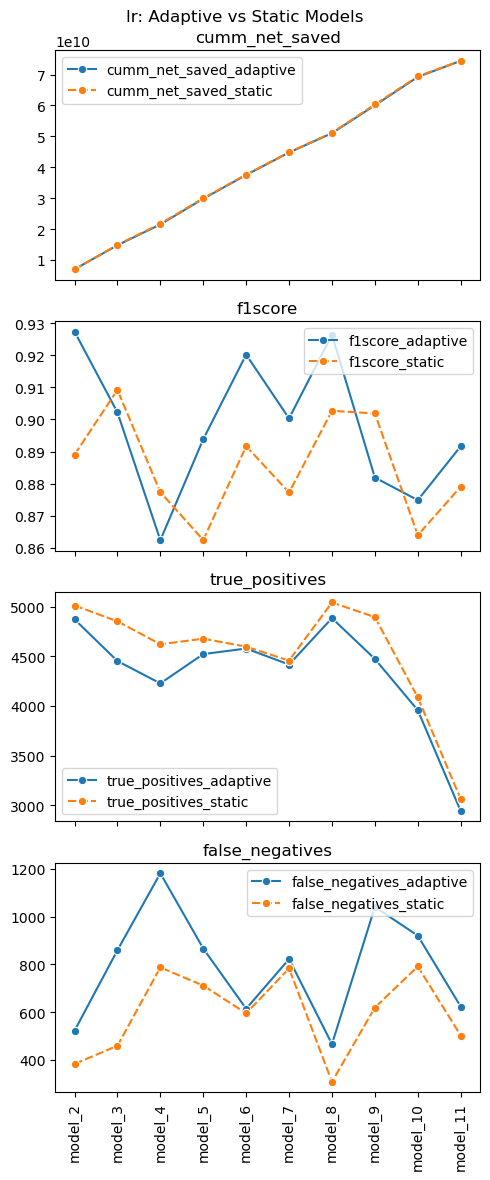

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [124]:
model = LogisticRegression(random_state=42)
periods = 12

results_lr = iterate_pipeline(X, y, model, periods, "lr")
results_lr

In [125]:
results_lr['combined_metrics_df']

,net_saved_adaptive,f1score_adaptive,true_positives_adaptive,false_negatives_adaptive,net_saved_static,f1score_static,true_positives_static,false_negatives_static,cumm_net_saved_adaptive,cumm_net_saved_static
model_2,6.980524e+09,0.927382,4872,522,7.001297e+09,0.889027,5011,383,6.980524e+09,7.001297e+09
model_3,7.806357e+09,0.902219,4452,859,7.900826e+09,0.909210,4852,459,1.478688e+10,1.490212e+10
model_4,6.727968e+09,0.862389,4227,1181,6.848977e+09,0.877350,4621,787,2.151485e+10,2.175110e+10
model_5,8.306373e+09,0.893853,4522,866,8.228492e+09,0.862438,4677,711,2.982122e+10,2.997959e+10
model_6,7.699682e+09,0.920201,4578,614,7.658065e+09,0.891669,4597,595,3.752090e+10,3.763766e+10
model_7,7.268230e+09,0.900326,4417,822,7.242984e+09,0.877252,4456,783,4.478913e+10,4.488064e+10
model_8,6.252610e+09,0.926404,4884,466,6.280772e+09,0.902694,5042,308,5.104174e+10,5.116141e+10
model_9,9.006885e+09,0.881901,4473,1040,9.157551e+09,0.901870,4894,619,6.004863e+10,6.031896e+10
model_10,9.184367e+09,0.874862,3957,920,9.112584e+09,0.863939,4086,791,6.923300e+10,6.943155e+10
model_11,5.197514e+09,0.891650,2942,623,5.039295e+09,0.879036,3063,502,7.443051e+10,7.447084e+10


Trained model_1
Trained model_2
Trained model_3
Trained model_4
Trained model_5
Trained model_6
Trained model_7
Trained model_8
Trained model_9
Trained model_10
Trained model_11


{'chart': <Figure size 500x1200 with 4 Axes>,
 'wilcoxon_stat': 8.0,
 'p-value': 0.048828125,
 'combined_metrics_df':           net_saved_adaptive  f1score_adaptive  true_positives_adaptive  \
 model_2         7.020493e+09          0.966956                     5121   
 model_3         7.226922e+09          0.948783                     4835   
 model_4         6.828325e+09          0.922437                     4656   
 model_5         8.276006e+09          0.918769                     4643   
 model_6         7.699551e+09          0.952750                     4789   
 model_7         7.140946e+09          0.911650                     4437   
 model_8         5.673875e+09          0.896566                     4373   
 model_9         8.963847e+09          0.936544                     4900   
 model_10        9.094103e+09          0.930546                     4274   
 model_11        5.350995e+09          0.950758                     3263   
 
           false_negatives_adaptive  net_save

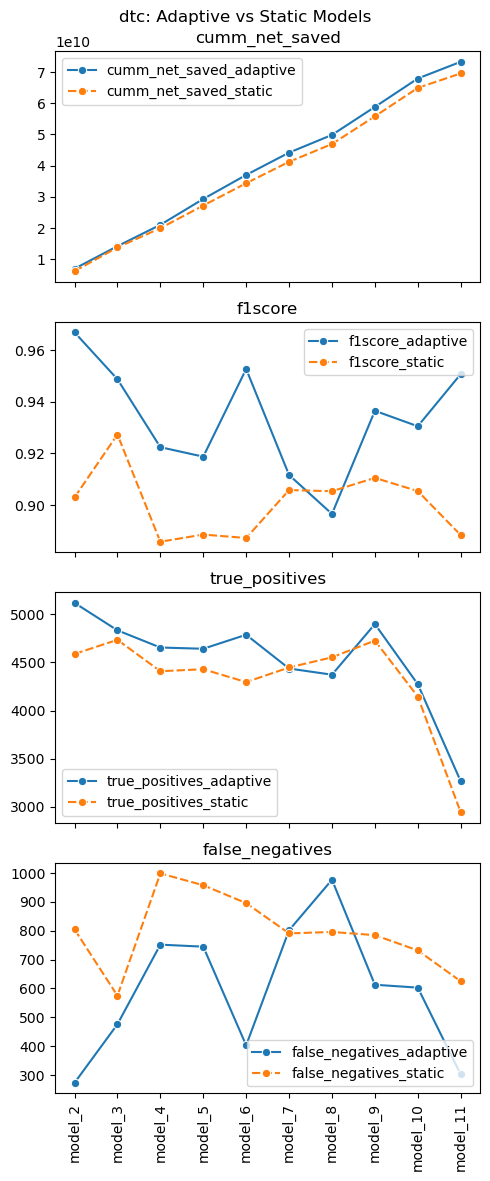

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [126]:
model = DecisionTreeClassifier(random_state=42)
periods = 12

results_dtc = iterate_pipeline(X, y, model, periods, 'dtc')
results_dtc

In [127]:
results_dtc["combined_metrics_df"]

,net_saved_adaptive,f1score_adaptive,true_positives_adaptive,false_negatives_adaptive,net_saved_static,f1score_static,true_positives_static,false_negatives_static,cumm_net_saved_adaptive,cumm_net_saved_static
model_2,7.020493e+09,0.966956,5121,273,6.228274e+09,0.902991,4589,805,7.020493e+09,6.228274e+09
model_3,7.226922e+09,0.948783,4835,476,7.607163e+09,0.927355,4736,575,1.424741e+10,1.383544e+10
model_4,6.828325e+09,0.922437,4656,752,6.166979e+09,0.885786,4409,999,2.107574e+10,2.000242e+10
model_5,8.276006e+09,0.918769,4643,745,7.249054e+09,0.888577,4430,958,2.935175e+10,2.725147e+10
model_6,7.699551e+09,0.952750,4789,403,7.145488e+09,0.887237,4296,896,3.705130e+10,3.439696e+10
model_7,7.140946e+09,0.911650,4437,802,6.863395e+09,0.905814,4448,791,4.419224e+10,4.126035e+10
model_8,5.673875e+09,0.896566,4373,977,5.687182e+09,0.905368,4554,796,4.986612e+10,4.694754e+10
model_9,8.963847e+09,0.936544,4900,613,8.865223e+09,0.910544,4728,785,5.882996e+10,5.581276e+10
model_10,9.094103e+09,0.930546,4274,603,9.110256e+09,0.905417,4145,732,6.792407e+10,6.492301e+10
model_11,5.350995e+09,0.950758,3263,302,4.624507e+09,0.888352,2940,625,7.327506e+10,6.954752e+10


Trained model_1
Trained model_2
Trained model_3
Trained model_4
Trained model_5
Trained model_6
Trained model_7
Trained model_8
Trained model_9
Trained model_10
Trained model_11


{'chart': <Figure size 500x1200 with 4 Axes>,
 'wilcoxon_stat': 27.0,
 'p-value': 1.0,
 'combined_metrics_df':           net_saved_adaptive  f1score_adaptive  true_positives_adaptive  \
 model_2         6.939390e+09          0.883112                     4348   
 model_3         7.805589e+09          0.904024                     4460   
 model_4         6.751971e+09          0.852057                     4069   
 model_5         8.334065e+09          0.895335                     4568   
 model_6         7.619652e+09          0.901702                     4449   
 model_7         7.310386e+09          0.909398                     4577   
 model_8         6.282881e+09          0.926120                     4939   
 model_9         9.001560e+09          0.875641                     4355   
 model_10        9.275570e+09          0.877363                     3992   
 model_11        5.202090e+09          0.889733                     2929   
 
           false_negatives_adaptive  net_saved_stati

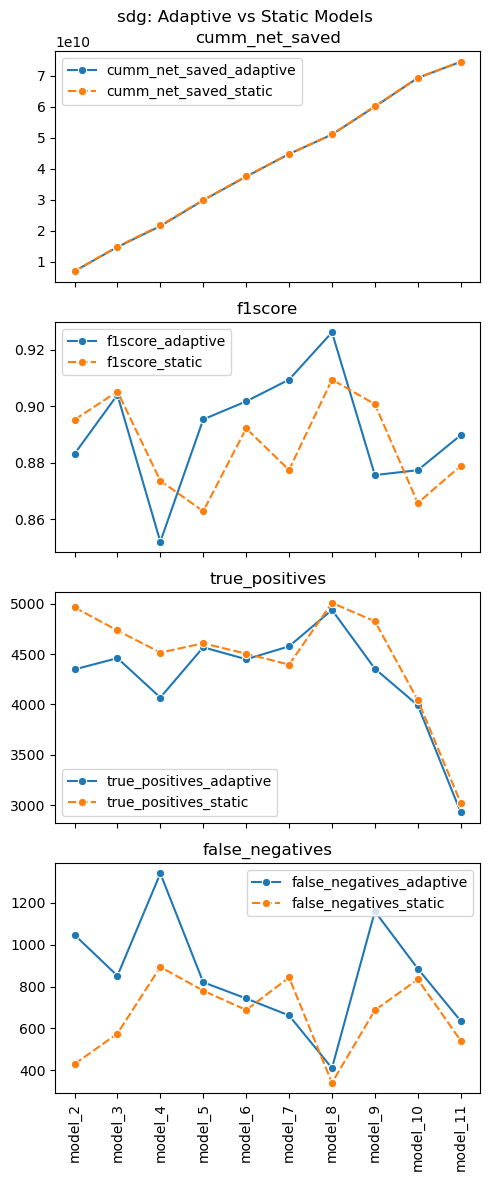

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [128]:
# GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
model = SGDClassifier(random_state=42)
periods = 12

results_sgd = iterate_pipeline(X, y, model, periods, 'sdg')
results_sgd

In [ ]:
model = AdaBoostClassifier(random_state=42)
periods = 12

results_abc = iterate_pipeline(X, y, model, periods, 'abc')
results_abc

## 4. Adding Explainability with SHAP

Best performing models, DecisionTreeClassifier models, will be used further

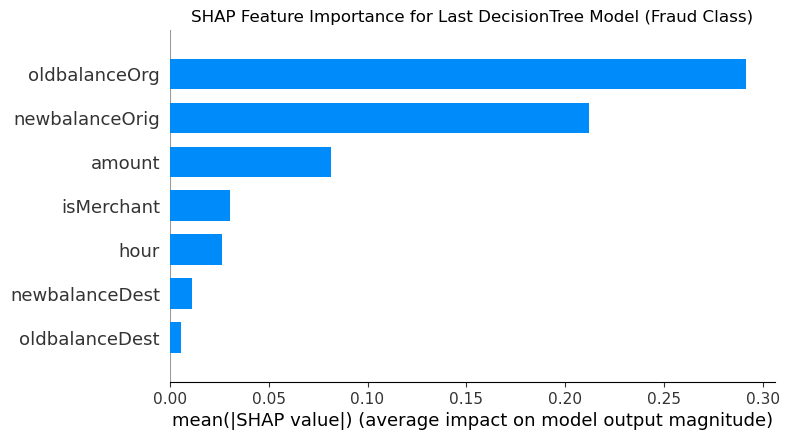

In [4]:
import shap

# Load the last DecisionTreeClassifier model
last_model_path = "models/dtc/model_11.pkl"
dtc_model = joblib.load(last_model_path)

# Load preprocessed data
X = pd.read_csv("data/processed/X_preprocessed.csv")
y = pd.read_csv("data/processed/y_preprocessed.csv").values.ravel()

# Select the evaluation period (period 12)
eval_mask = X['time_period'] == 12
X_eval = X[eval_mask][['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
                       'newbalanceDest', 'hour', 'isMerchant']]
y_eval = y[eval_mask]

# Fit SHAP explainer
explainer = shap.TreeExplainer(dtc_model)
shap_values = explainer.shap_values(X_eval)

# Plot summary for class 1 (fraud)
shap.summary_plot(shap_values[1], X_eval, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for Last DecisionTree Model (Fraud Class)")
plt.show()

In [ ]:
def predict_and_explain(model, X_test, feature_names=None, class_idx=1, plot_type="bar"):
    """
    Loads test data, predicts with the model, computes SHAP values, and plots feature importance.

    Args:
        model: Trained tree-based model (e.g., DecisionTreeClassifier, RandomForestClassifier).
        X_test (pd.DataFrame): Test data (features only).
        feature_names (list, optional): List of feature names for SHAP plot. If None, uses X_test.columns.
        class_idx (int): Class index for SHAP summary plot (default: 1 for fraud).
        plot_type (str): SHAP summary plot type ("bar" or "dot").

    Returns:
        y_pred (np.ndarray): Model predictions.
        shap_values (list or np.ndarray): SHAP values.
    """
    import matplotlib.pyplot as plt

    # Predict
    y_pred = model.predict(X_test)

    # SHAP explain
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Feature names
    if feature_names is None:
        feature_names = X_test.columns

    # Plot SHAP summary for specified class
    shap.summary_plot(shap_values[class_idx], X_test, feature_names=feature_names, plot_type=plot_type, show=False)
    plt.title(f"SHAP Feature Importance (Class {class_idx})")
    plt.show()

    return y_pred, shap_values

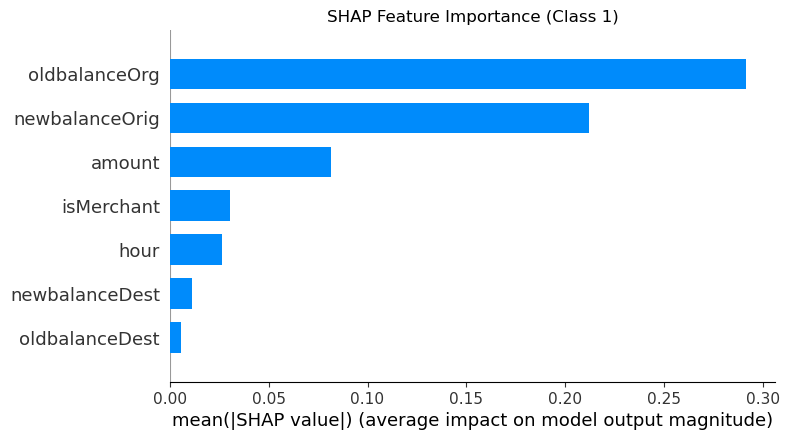

Predictions shape: (10047,)
SHAP values type: <class 'list'>


In [10]:
# Example usage of predict_and_explain with sample data

# Use the already loaded dtc_model and X_eval from previous cells
# X_eval contains the correct feature columns for the DecisionTreeClassifier

y_pred, shap_vals = predict_and_explain(
    model=dtc_model,
    X_test=X_eval,
    feature_names=X_eval.columns,
    class_idx=1,
    plot_type="bar"
)

print("Predictions shape:", y_pred.shape)
print("SHAP values type:", type(shap_vals))

In [51]:
X_eval.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,hour,isMerchant
163215,0.897914,0.059109,-0.281613,-0.329410,-0.352762,-1.308753,0
163216,0.897914,0.059109,-0.281613,-0.326832,-0.049780,-1.308753,0
163217,-0.029065,-0.219844,-0.281613,-0.329410,-0.352762,-1.308753,0
163218,-0.029065,-0.219844,-0.281613,-0.297685,-0.255178,-1.308753,0
163219,2.016155,0.395618,-0.281613,-0.329410,-0.352762,-1.308753,0


In [14]:
(y_pred == y_eval).mean()

0.9663581168508012

In [35]:
def scale_data(data):
    """ scale input using scaler model"""
    features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'hour']
    to_scale = data[features]

    # load scaler model
    scaler = joblib.load("models/scaler.pkl")
    scaled_data = scaler.transform(to_scale)

    scaled_data = pd.DataFrame(scaled_data, columns=to_scale.columns)
    
    # bring isMerchant back in
    scaled_data['isMerchant'] = data['isMerchant']

    return scaled_data

in case I forget, here's what I was trying to do:
- I'll ensure I get this data in the dataframe format I want
- Then I'll try predicting directly with it, without scaling, and see if I get the same issue I've been getting.
- Then I'll apply the scaler and predict again, and see if I get something different.
- Then I'll put the scaler in the pipeline for the app.
- If that works, I'm all done. I'll go ahead with the writing.

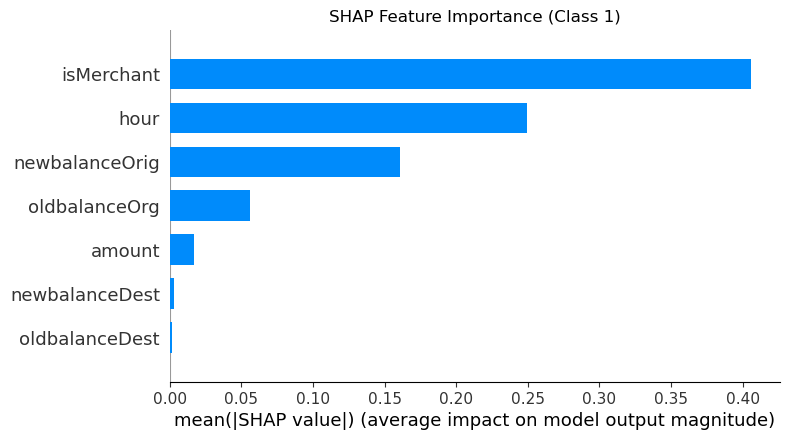

[0]


In [55]:
test_X = pd.DataFrame({
    "amount": [1200],
    "oldbalanceOrg": [10000],
    "newbalanceOrig": [8800],
    "oldbalanceDest": [20000],
    "newbalanceDest": [4200],
    "hour": [8],
    "isMerchant": [1]
})

test_X = scale_data(test_X)
y_pred, shap_vals = predict_and_explain(dtc_model, test_X)
print(y_pred)

In [52]:
test_X

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,hour,isMerchant
0,-0.299203,-0.298112,-0.278513,-0.328793,-0.351559,-1.524453,0


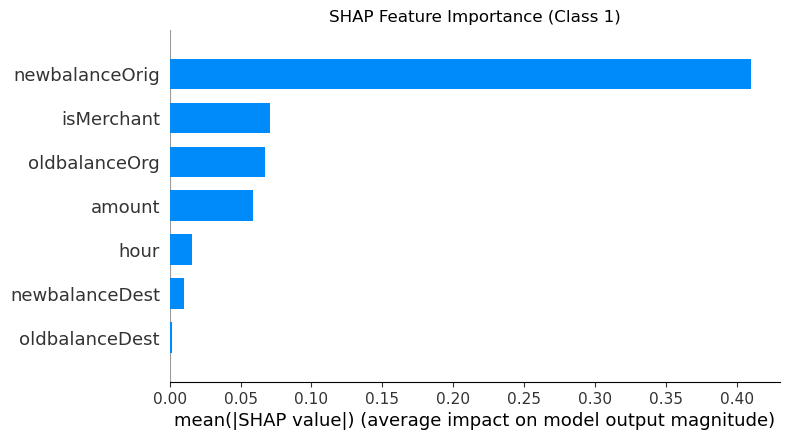

[0] [1.]


In [71]:
test_X = pd.DataFrame({
    "amount": [1200],
    "oldbalanceOrg": [10000],
    "newbalanceOrig": [8800],
    "oldbalanceDest": [20000],
    "newbalanceDest": [4200],
    "hour": [12],
    "isMerchant": [0]
})

test_X = scale_data(test_X)
y_pred, shap_vals = predict_and_explain(dtc_model, test_X)
print(y_pred, dtc_model.predict_proba(test_X)[0][y_pred])